In [66]:
import pyqsp
from pyqsp.LPoly import *
import jax
import jax.numpy as jnp
import numpy as np
from tqdm.notebook import tqdm
from scipy.interpolate import approximate_taylor_polynomial
from matplotlib import pyplot as plt
import copy

In [67]:
# Generates the polynomials corresponding to inverse Chebyshev polynomials
def B(x):
    # The half-angle function
    return np.sqrt(0.5 + 0.5 * np.sqrt((1 + x)/2))

def C(x):
    # The other half-angle function
    return 0.5 * (1 / np.sqrt(1 + x)) * (1 / np.sqrt(1 + np.sqrt((1 + x)/2)))

def generate_BC(n, delta):
    # Generates the Taylor approximations
    B_coeffs, C_coeffs = approximate_taylor_polynomial(B, 0, n, 1 - delta), approximate_taylor_polynomial(C, 0, n-1, 1 - delta)
    return np.polynomial.Polynomial(B_coeffs.coeffs[::-1]), np.polynomial.Polynomial(C_coeffs.coeffs[::-1])

In [68]:
delta = 0.05
degree = 12

# Generates the polynomial approximations
B_poly, C_poly = generate_BC(degree, delta)

In [69]:
X = np.linspace(-1, 1, 500)

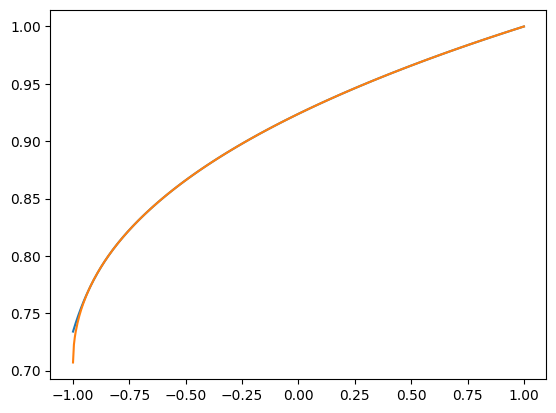

In [70]:
Y = B_poly(X)
plt.plot(X, Y)
plt.plot(X, B(X))

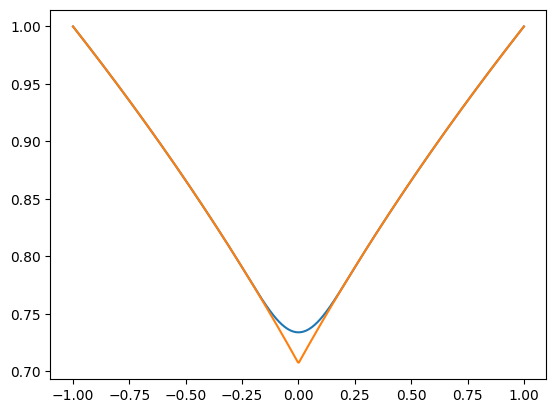

In [71]:
Y = B_poly(2 * X ** 2 - 1)
plt.plot(X, Y)
plt.plot(X, B(2 * X ** 2 - 1))

/var/folders/yd/_p7ptfl11dqffr29bbsh4wyw0000gn/T/ipykernel_11908/2798939907.py:8: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 / np.sqrt(1 + x)) * (1 / np.sqrt(1 + np.sqrt((1 + x)/2)))


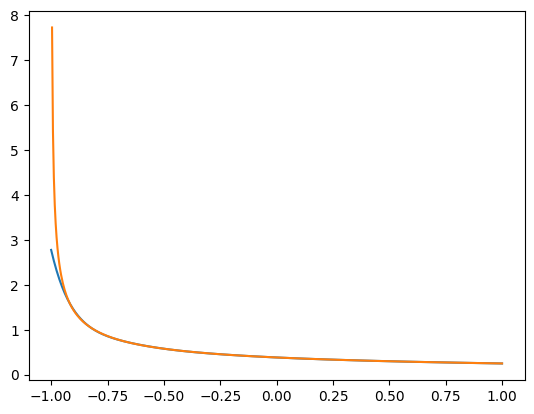

In [72]:
Y = C_poly(X)
plt.plot(X, Y)
plt.plot(X, C(X))

/var/folders/yd/_p7ptfl11dqffr29bbsh4wyw0000gn/T/ipykernel_11908/2798939907.py:8: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 / np.sqrt(1 + x)) * (1 / np.sqrt(1 + np.sqrt((1 + x)/2)))
/var/folders/yd/_p7ptfl11dqffr29bbsh4wyw0000gn/T/ipykernel_11908/3923913453.py:3: RuntimeWarning: invalid value encountered in multiply
  Y_norm_real = (B(X_norm) ** 2) + (1 - X_norm ** 2) * (C(X_norm) ** 2)


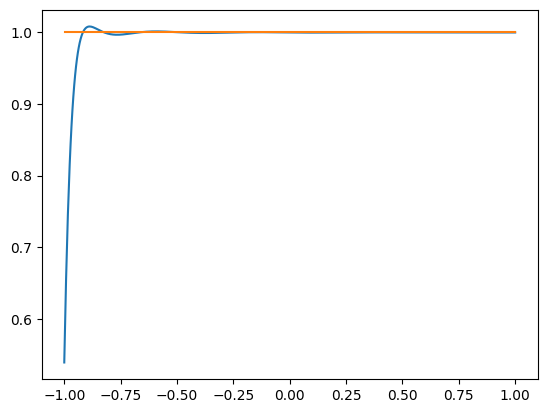

In [73]:
X_norm = np.linspace(-1, 1, 500)
Y_norm = (B_poly(X_norm) ** 2) + (1 - X_norm ** 2) * (C_poly(X_norm) ** 2)
Y_norm_real = (B(X_norm) ** 2) + (1 - X_norm ** 2) * (C(X_norm) ** 2)

plt.plot(X, Y_norm)
plt.plot(X, Y_norm_real)

In [52]:
# Generates the Chebyshev coefficients
from scipy.special import chebyt, chebyu

def poly2chebyfn(pcoefs, kind="T"):
    P = copy.deepcopy(pcoefs)
    if kind == "T":
        cfunc = lambda x : list(reversed(chebyt(x).coef))
    elif kind == "U":
        cfunc = lambda x : list(reversed(chebyu(x).coef))

    deg = len(P)-1
    C = []
    for l in range(deg, -1, -1):
        r = P[l]
        poly_term = cfunc(l)
        
        C.append(r / poly_term[len(poly_term)-1])
        P = P - (r / poly_term[len(poly_term)-1])  * np.array(cfunc(l) + [0.0 for _ in range(l, deg)])
    return list(reversed(C))

In [53]:
B_cheb, C_cheb = poly2chebyfn(B_poly.coef, kind="T") / max(abs(Y_norm)), poly2chebyfn(C_poly.coef, kind="U") / max(abs(Y_norm))

In [54]:
# Constructs the coefficients of the Laurent polynomial
L_coeffs = list(reversed(list((B_cheb[1:] - C_cheb)/2))) + [B_cheb[0]] + list((B_cheb[1:] + C_cheb)/2)

In [55]:
def eval_L(L_coeffs):
    def fn(angles):
        return np.dot(L_coeffs, np.exp(1j * np.outer(np.arange(-2 * degree, 2 * degree + 1, 2), angles)))
    return fn

In [56]:
func = eval_L(L_coeffs)

In [57]:
Theta = np.linspace(-np.pi, np.pi, 500)
Vals = func(Theta)
Real_vals = np.exp(1j * Theta / 2)

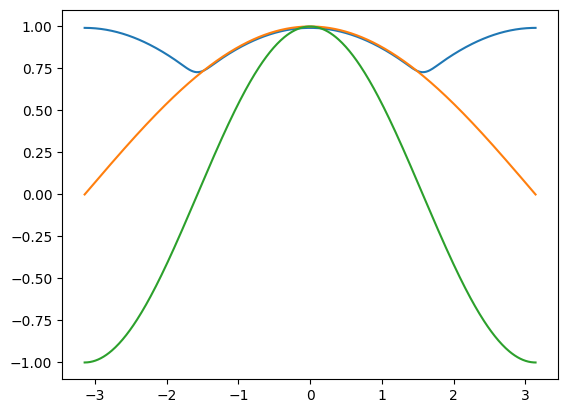

In [58]:
plt.plot(Theta, Vals)
plt.plot(Theta, Real_vals)
plt.plot(Theta, np.cos(Theta))

In [59]:
L_coeffs

[0.0003411438626467547,
 -0.001346159266463324,
 0.0030829881343529533,
 -0.005594172722391845,
 0.009102440025556711,
 -0.013853732468478227,
 0.020267103097087864,
 -0.028994560906801314,
 0.04134425473536277,
 -0.060201588233558125,
 0.09371170931340381,
 -0.17625222396941406,
 0.8937978401929872,
 0.2934007477577299,
 -0.1201969236886194,
 0.07088834829840206,
 -0.04662817903012409,
 0.03184803381054379,
 -0.0218639169273581,
 0.014746556591393145,
 -0.009589088447266454,
 0.005843047934782416,
 -0.003198174911041872,
 0.0013892483830315102,
 -0.00035176731870199243]

In [60]:
# Performs the QSP completion of the Laurent polynomial
seq = pyqsp.angle_sequence.QuantumSignalProcessingPhases(np.array(L_coeffs), signal_operator="Wz", measurement="z", tolerance=2)

In [61]:
f = lambda x : (pyqsp.gadgets.Rx(np.pi/4) @ pyqsp.gadgets.compute_mqsp_unitary([pyqsp.gadgets.W(x) @ pyqsp.gadgets.Rx(-np.pi/2)], seq, [0 for _ in range(len(seq)-1)], rot_gate="z"))[0][1]
g = lambda x : (pyqsp.gadgets.Rx(np.pi/4) @ pyqsp.gadgets.compute_mqsp_unitary([pyqsp.gadgets.W(x) @ pyqsp.gadgets.Rx(-np.pi/2)], seq, [0 for _ in range(len(seq)-1)], rot_gate="z"))[0][0]

In [62]:
YY = [f(x) for x in X_norm]
YZ = [g(x) for x in X_norm]

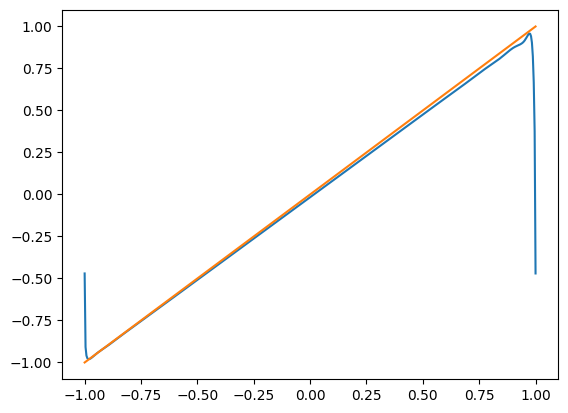

In [63]:
#plt.plot(X_norm, np.imag(YY))
plt.plot(X_norm, 2 * np.real(YZ) ** 2 - 1)
plt.plot(X_norm, X_norm)

#plt.plot(X_norm, np.cos(np.arccos(X_norm)/2))
#plt.plot(X_norm, np.sin(np.arccos(X_norm)/2))

#plt.plot(X_norm, np.imag(YZ))
#plt.plot(X_norm, np.real(YY))

In [943]:
adat = np.linspace(-1, 1, 500)
response = pyqsp.response.ComputeQSPResponse(
    adat,
    np.array(seq),
    signal_operator="Wz",
    measurement="z")["pdat"]

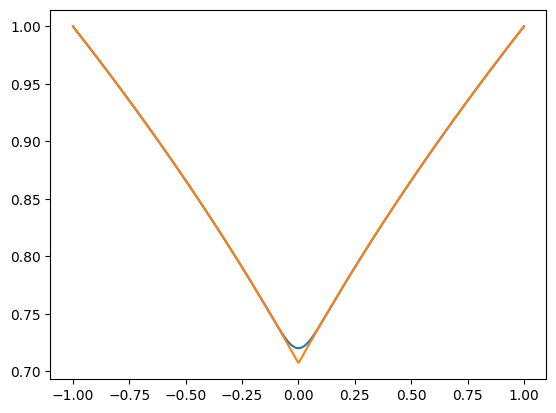

In [944]:
plt.plot(adat, np.real(response))
plt.plot(X_norm, [B(2 * x ** 2 - 1) for x in X_norm])